## Tensor backbone

In [16]:
from dataclasses import dataclass
from typing import Union, List, Callable, Optional, Tuple, Literal

import numpy as np

Scalar = Union[int, float]

Data = Union[Scalar, list, np.ndarray, "Tensor"]


@dataclass(frozen=True)
class Leaf:
    value: "Tensor"
    grad_fn: Callable[[np.ndarray], np.ndarray]


class Tensor:
    def __init__(
        self,
        data: Data,
        requires_grad: bool = False,
        dependencies: Optional[List[Leaf]] = None,
        dtype=np.float32
    ):
        self._data = Tensor.build_ndarray(data, dtype)
        self.dtype = dtype

        self.requires_grad = requires_grad
        self.dependencies = dependencies or []

        self.grad = np.zeros_like(self._data) if requires_grad else None

    @property
    def data(self) -> np.ndarray:
        return self._data

    @data.setter
    def data(self, data: Data):
        self._data = Tensor.build_ndarray(data, self.dtype)
        if self.requires_grad:
            self.zero_grad()

    @property
    def size(self) -> int:
        return self.data.size

    @property
    def shape(self) -> Tuple[int, ...]:
        return self.data.shape

    @property
    def ndim(self) -> int:
        return self.data.ndim

    @staticmethod
    def build_ndarray(data: Data, dtype=np.float32) -> np.ndarray:
        if isinstance(data, Tensor):
            return np.array(data.data, dtype=dtype)
        if isinstance(data, np.ndarray):
            return data.astype(dtype)
        return np.array(data, dtype=dtype)

    @staticmethod
    def data_gate(data_object: Data) -> "Tensor":
        if isinstance(data_object, Tensor):
            return data_object
        return Tensor(data_object)

    def __repr__(self):
        return f"Tensor({self.data}, requires_grad={self.requires_grad}, shape={self.shape})"

    def zero_grad(self):
        if self.grad is None:
            self.grad = np.zeros_like(self._data)
        else:
            self.grad.fill(0.0)

    def backward(self, grad: Optional[np.ndarray] = None) -> None:
        if not self.requires_grad:
            raise RuntimeError(
                "Cannot call backward() on a tensor that does not require gradients. "
                "If you need gradients, ensure that requires_grad=True when creating the tensor."
            )

        if grad is None:
            if self.shape == ():
                grad = np.array(1.0)
            else:
                raise ValueError("Grad must be provided if tensor has shape")
            
        self.grad = self.grad + grad

        for dependency in self.dependencies:
            backward_grad = dependency.grad_fn(grad)
            dependency.value.backward(backward_grad)

    def view(self, shape: Tuple[int, ...], stride: Tuple[int, ...] = None) -> "Tensor":
        if stride is None:
            stride = self.data.strides  # Use default strides if not specified

        output = self.data.reshape(shape)  # Reshape without copying data
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                return grad.reshape(self.shape)  # Reshape back to original shape

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        return Tensor(output, self.requires_grad, dependencies, dtype=self.dtype)

    def clip(self, min_value: Optional[float] = None, max_value: Optional[float] = None) -> "Tensor":
        # Perform clipping on the data
        output = np.clip(self.data, min_value, max_value)

        # Track dependencies if requires_grad is True
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                # Create a mask for values within the clipping range
                mask = np.ones_like(self.data)

                # Apply the mask
                if min_value is not None:
                    mask[self.data <= min_value] = 0
                if max_value is not None:
                    mask[self.data >= max_value] = 0

                # Multiply the gradient by the mask
                return grad * mask

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        # Return a new tensor with the clipped values and dependencies
        return Tensor(output, self.requires_grad, dependencies)

    def __getitem__(self, index) -> "Tensor":
        # Perform indexing operation
        output = self.data[index]

        # Track dependencies if requires_grad is True
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                full_grad = np.zeros_like(self.data)
                full_grad[index] = grad
                return full_grad

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        # Return a new tensor with the indexed data and dependencies
        return Tensor(output, self.requires_grad, dependencies)

    # Comparison Operators

    def __lt__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return Tensor(self.data < other.data)

    def __gt__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return Tensor(self.data > other.data)

    def __eq__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return Tensor(self.data == other.data)

    def __le__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return Tensor(self.data <= other.data)

    def __ge__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return Tensor(self.data >= other.data)

    def __ne__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return Tensor(self.data != other.data)

    @staticmethod
    def where(condition: "Tensor", a: "Tensor", b: "Tensor") -> "Tensor":
        output = np.where(condition.data, a.data, b.data)  # Element-wise selection
        requires_grad = a.requires_grad or b.requires_grad
        dependencies: List[Leaf] = []

        if a.requires_grad:
            def _bkwd_a(grad: np.ndarray) -> np.ndarray:
                return np.where(condition.data, grad, 0.0)

            dependencies.append(Leaf(a, _bkwd_a))

        if b.requires_grad:
            def _bkwd_b(grad: np.ndarray) -> np.ndarray:
                return np.where(condition.data, 0.0, grad)

            dependencies.append(Leaf(b, _bkwd_b))

        return Tensor(output, requires_grad, dependencies)

    def transpose(self, axes: Tuple[int, ...] = None) -> "Tensor":
        # Perform the transpose operation
        output = np.transpose(self.data, axes=axes)

        # Handle dependencies for autograd
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                # Compute the inverse permutation of axes for the backward function
                if axes is None:
                    # Implicitly reverses transpose
                    return np.transpose(grad)  
                else:
                    # Compute the inverse permutation of axes
                    inv_axes = tuple(np.argsort(axes))
                    # Transpose the gradient back using the inverse permutation
                    return np.transpose(grad, axes=inv_axes)

            dependencies.append(
                Leaf(value=self, grad_fn=_bkwd)
            )

        # Return the new tensor with the transposed data
        return Tensor(
            output,
            requires_grad=self.requires_grad,
            dependencies=dependencies
        )

    @property
    def T(self):
        return self.transpose()

    def squeeze(self, axis: Union[int, Tuple[int], None] = None) -> "Tensor":
        output = np.squeeze(self.data, axis=axis)
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                if axis is None:
                    # No expansion needed if all singleton dims were removed
                    return grad
                return np.expand_dims(grad, axis=axis)

            dependencies.append(
                Leaf(value=self, grad_fn=_bkwd)
            )

        return Tensor(output, self.requires_grad, dependencies)
    
    def unsqueeze(self, dim: int) -> "Tensor":
        output: np.ndarray = np.expand_dims(self.data, axis=dim)
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                if output.shape[dim] == 1:  # Only squeeze if the added dim was size 1
                    return np.squeeze(grad, axis=dim)
                return grad

            dependencies.append(
                Leaf(value=self, grad_fn=_bkwd)
            )

        return Tensor(output, self.requires_grad, dependencies)

    @staticmethod
    def matmul(a: "Tensor", b: "Tensor") -> "Tensor":
        output = a.data @ b.data
        requires_grad = a.requires_grad or b.requires_grad
        dependencies: List[Leaf] = []

        if a.requires_grad:
            def _bkwd_a(grad: np.ndarray) -> np.ndarray:
                if b.ndim > 1:
                    return grad @ b.data.swapaxes(-1, -2)

                # Handle case where b is a vector
                return np.outer(grad, b.data.T).squeeze()

            dependencies.append(
                Leaf(
                    value=a,
                    grad_fn=_bkwd_a
                )
            )

        if b.requires_grad:
            def _bkwd_b(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward gradient function for matmul with respect to b.
                """
                if a.ndim > 1:
                    return a.data.swapaxes(-1, -2) @ grad

                # Handle case where a is a vector
                return np.outer(a.data.T, grad).squeeze()
            
            dependencies.append(
                Leaf(
                    value=b,
                    grad_fn=_bkwd_b
                )
            )

        return Tensor(output, requires_grad, dependencies)

    def dot(self, other: Data) -> "Tensor":
        return Tensor.matmul(self, Tensor.data_gate(other))

    def __matmul__(self, other: Data) -> "Tensor":
        return self.dot(other)

    def abs(self) -> "Tensor":
        # Perform absolute value operation on the data
        output = np.abs(self.data)

        # Initialize the list of dependencies for gradient calculation
        dependencies: List[Leaf] = []

        # Backward function to compute the gradient for the absolute value operation
        def _bkwd(grad: np.ndarray) -> np.ndarray:
            # The derivative of abs(x) is the sign of x: 1 for positive x, -1 for negative x
            return grad * np.sign(self.data)

        # If the tensor requires gradients, add the backward function to the dependencies list
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,  # The input tensor
                    grad_fn=_bkwd  # The backward function to compute the gradients
                )
            )

        # Return a new tensor containing the absolute values, with the gradient dependencies if needed
        return Tensor(output, self.requires_grad, dependencies)

    def max(self, axis: Optional[int] = None, keepdims: bool = False) -> "Tensor":
        # Compute the maximum along the specified axis
        output = np.max(self.data, axis=axis, keepdims=keepdims)

        # Track dependencies if requires_grad is True
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                grad_expanded = np.expand_dims(grad, axis) if axis is not None else grad
                mask = self.data == np.expand_dims(output, axis) if axis is not None else self.data == output
                return grad_expanded * mask.astype(self.data.dtype)

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        return Tensor(output, self.requires_grad, dependencies)

    def sum(self, axis: int = None, keepdims: bool = False) -> "Tensor":
        # Perform summation over specified axis
        output = self.data.sum(axis=axis, keepdims=keepdims)

        # Initialize the list of dependencies for gradient calculation
        dependencies: List[Leaf] = []

        # Backward function to calculate the gradients for the sum operation
        def _bkwd(grad: np.ndarray) -> np.ndarray:
            if keepdims:
                # If keepdims is True, we need to expand the gradient dimensions to match the input tensor
                expanded_grad = np.expand_dims(grad, axis=axis)
                ones = np.ones_like(expanded_grad)  # Create a tensor of ones to match the expanded gradient
                grad = expanded_grad * ones  # Broadcast the gradient to the correct shape
            # Sum the gradients along the specified axis
            return np.sum(grad, axis=axis)

        # If the tensor requires gradients, add the backward function to the dependencies list
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,  # The input tensor
                    grad_fn=_bkwd  # The backward function to compute the gradients
                )
            )

        # Return a new tensor containing the sum, with the gradient dependencies if needed
        return Tensor(output, self.requires_grad, dependencies)

    def mean(self, axis: Optional[int] = None, keepdims: bool = False) -> "Tensor":
        # Mean is simply sum divided by the size of the tensor
        # First, we calculate the sum of all elements, then divide by the total number of elements (size)
        return self.sum(axis=axis, keepdims=keepdims) / self.size

    def log(self) -> "Tensor":
        # Perform logarithmic operation on the data
        output = np.log(self.data)
        
        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            # The derivative of log(x) is 1/x, so we divide the gradient by the data (x)
            return grad / self.data

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the log operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    def tanh(self) -> "Tensor":
        # Perform hyperbolic tangent operation on the data
        output = np.tanh(self.data)
        
        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:            
            # The derivative of tanh(x) is 1 - tanh(x)^2, so we multiply the gradient by this value
            return grad * (1 - output**2)

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the tanh operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    def pow(self, pow: Scalar) -> "Tensor":
        # Perform element-wise power operation (raise each element to the given power)
        output = self.data**pow
        
        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            # The derivative of x^pow is pow * x^(pow - 1), so we multiply the gradient by this value
            return grad * (pow * (self.data**(pow - 1)))

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the power operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    def __pow__(self, pow: Scalar) -> "Tensor":
        return self.pow(pow)
    
    def exp(self) -> "Tensor":
        # Perform element-wise exponential operation (raise e to the power of each element)
        output = np.exp(self.data)

        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            # The derivative of e^x is e^x, so we multiply the gradient by the output value
            return grad * output

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the exponential operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    @staticmethod
    def _bkwd_broadcast(tensor: "Tensor"):
        def _bkwd(grad: np.ndarray) -> np.ndarray:
            # Handle scalar case
            if grad.ndim == 0:
                return grad

            # For handling broadcasting, we need to sum over all dimensions 
            # that were broadcast
            ndim_added = grad.ndim - tensor.ndim

            # Sum over dimensions that were added during broadcasting
            for _ in range(ndim_added):
                grad = grad.sum(axis=0)

            # For dimensions that exist in both tensors, sum over ones
            # where the tensor had size 1 (these were broadcast)
            for i in range(min(tensor.ndim, grad.ndim)):
                if i < len(tensor.shape) and tensor.shape[i] == 1:
                    grad = grad.sum(axis=i, keepdims=True)

            # Ensure the final shape matches the tensor shape exactly
            if grad.shape != tensor.shape:
                grad = grad.reshape(tensor.shape)

            return grad
        return _bkwd

    @staticmethod
    def add(a: "Tensor", b: "Tensor") -> "Tensor":
        # Perform element-wise addition of the data of tensors a and b
        output = a.data + b.data
        
        # Determine if the result requires gradients (if any input tensor requires it)
        requires_grad = a.requires_grad or b.requires_grad
        
        # List to store dependencies (grad functions) for backpropagation
        dependencies: List[Leaf] = []

        # If tensor a requires gradients, add its gradient function to dependencies
        if a.requires_grad:
            dependencies.append(
                Leaf(value=a, grad_fn=Tensor._bkwd_broadcast(a))
            )

        # If tensor b requires gradients, add its gradient function to dependencies
        if b.requires_grad:
            dependencies.append(
                Leaf(value=b, grad_fn=Tensor._bkwd_broadcast(b))
            )

        # Return a new tensor with the result, gradient flag, and dependencies
        return Tensor(output, requires_grad, dependencies)
    
    def __add__(self, other: Data) -> "Tensor":
        return Tensor.add(self, Tensor.data_gate(other))

    def __radd__(self, other: Data) -> "Tensor":
        return Tensor.add(Tensor.data_gate(other), self)

    def __iadd__(self, other: Data) -> "Tensor":
        self.data = self.data + Tensor.build_ndarray(other)
        return self

    def __neg__(self) -> "Tensor":
        output = -self.data
        dependencies: List[Leaf] = []

        # Define the backward function: gradient negation
        if self.requires_grad:
            dependencies.append(
                Leaf(value=self, grad_fn=lambda grad: -grad)
            )

        return Tensor(output, self.requires_grad, dependencies)

    def __sub__(self, other: Data) -> "Tensor":
        return self + (-Tensor.data_gate(other))

    def __rsub__(self, other: Data) -> "Tensor":
        return Tensor.data_gate(other) + (-self)

    def __isub__(self, other: Data) -> "Tensor":
        self.data = self.data - Tensor.build_ndarray(other)
        return self
    
    @staticmethod
    def mul(a: "Tensor", b: "Tensor") -> "Tensor":
        # Ensure both tensors contain their data correctly, handling any potential gates
        a = Tensor.data_gate(a)
        b = Tensor.data_gate(b)

        # Perform element-wise multiplication on the tensor data
        output = a.data * b.data

        # Determine if the resulting tensor should require gradients
        requires_grad = a.requires_grad or b.requires_grad
        dependencies: List[Leaf] = []

        # Define the backward pass function for multiplication
        def _backward(a: Tensor, b: Tensor):
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                # Multiply the gradient by tensor b's data for the gradient w.r.t a
                grad = grad * b.data
                # Ensure the gradient is properly reshaped using broadcasting
                return Tensor._bkwd_broadcast(a)(grad)

            return _bkwd

        # If tensor a requires gradients, add the backward function to the dependencies
        if a.requires_grad:
            dependencies.append(
                Leaf(
                    value=a,
                    grad_fn=_backward(a, b)  # Link tensor a's backward pass
                )
            )

        # If tensor b requires gradients, add the backward function to the dependencies
        if b.requires_grad:
            dependencies.append(
                Leaf(
                    value=b,
                    grad_fn=_backward(b, a)  # Link tensor b's backward pass
                )
            )

        # Return the result as a new tensor, with the appropriate gradient information
        return Tensor(output, requires_grad, dependencies)

    def __mul__(self, other: Data) -> "Tensor":
        return Tensor.mul(self, Tensor.data_gate(other))

    def __rmul__(self, other: Data) -> "Tensor":
        return Tensor.mul(Tensor.data_gate(other), self)

    def __imul__(self, other: Data) -> "Tensor":
        self.data = self.data * Tensor.build_ndarray(other)
        return self

    def __truediv__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return self * (other**-1)

    def __rtruediv__(self, other: Data) -> "Tensor":
        other = Tensor.data_gate(other)
        return other * (self**-1)

    def __itruediv__(self, other: Data) -> "Tensor":
        self.data = self.data / Tensor.build_ndarray(other)
        return self

## Chain Rule

$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

If we have a function composition:  

$$
f(x) = g(h(x))
$$

Then, by the chain rule:

$$
f'(x) = g'(h(x)) \cdot h'(x)
$$

In [17]:
t = Tensor([1, 2, 3], requires_grad=True)
t.data = [[1, 3, 5], [2, 3, 4]]
t_T = t.T

t_T.backward(np.ones_like(t_T.data))

In [18]:
InitMethod = Literal["xavier", "he", "he_leaky", "normal", "uniform"]


class Parameter(Tensor):
    def __init__(
        self,
        *shape: int,
        data: Optional[np.ndarray] = None,
        init_method: InitMethod = "xavier",
        gain: float = 1.0,
        alpha: float = 0.01,
    ):
        if data is None:
            data = self._init(shape, init_method, gain, alpha)

        super().__init__(data=data, requires_grad=True)

    def _init(
        self,
        shape: Tuple[int, ...], 
        init_method: InitMethod = "xavier", 
        gain: float = 1.0, 
        alpha: float = 0.01
    ):
        weights = np.random.randn(*shape)

        if init_method == "xavier":
            std = gain * np.sqrt(1.0 / shape[0])
            return std * weights
        if init_method == "he":
            std = gain * np.sqrt(2.0 / shape[0])
            return std * weights
        if init_method == "he_leaky":
            std = gain * np.sqrt(2.0 / (1 + alpha**2) * (1 / shape[0]))
            return std * weights
        if init_method == "normal":
            return gain * weights
        if init_method == "uniform":
            return gain * np.random.uniform(-1, 1, size=shape)

        raise ValueError(f"Unknown initialization method: {init_method}")

In [19]:
from typing import List

class Module:
    def __call__(self, *args, **kwds) -> Tensor:
        return self.forward(*args, **kwds)

    def forward(self, *args, **kwds):
        raise NotImplementedError()

    def parameters(self) -> List[Parameter]:
        r"""
        Returns a list of all parameters in the module and its submodules.
        """
        params = []
        for _, item in self.__dict__.items():
            if isinstance(item, Parameter):
                params.append(item)
            elif isinstance(item, Module):
                params.extend(item.parameters())
        return params

    def zero_grad(self) -> None:
        r"""
        Zeroes the gradients of all parameters in the module and its submodules.
        """
        for param in self.parameters():
            param.zero_grad()

    def params_count(self) -> int:
        r"""
        Returns:
            int: Number of parameters
        """

        num_parameters = sum(p.data.size for p in self.parameters())
        return num_parameters


class Sequential(Module):
    def __init__(self, *modules: Module):
        self.modules = modules

    def parameters(self) -> List[Parameter]:
        r"""
        Returns a list of all parameters in the sequential module and its submodules.
        """
        params = []
        for module in self.modules:
            params.extend(module.parameters())
        return params

    def forward(self, x):
        r"""
        Passes the input through all modules in sequence.
        """
        for module in self.modules:
            x = module(x)
        return x



## Linear Layer

At layer $i$, the transformation is defined as:  

$$A_i(\mathbf{X}) = \mathbf{X} \mathbf{W}_i^T + \mathbf{B}_i$$

Where $\mathbf{X}$ is the input matrix (batch of samples), $\mathbf{W}_i^T$ represents the weight matrix, and $\mathbf{B}_i$ is the bias matrix, typically broadcasted across the batch. The activation function $\sigma$ introduces non-linearity after this transformation.

For a single layer:  

$$F_i(\mathbf{X}) = \sigma(A_i(\mathbf{X}))$$

where $A_i(\mathbf{X})$ is the linear transformation at layer $i$.  

A deep neural network applies these transformations layer by layer, leading to the final output:  

$$F(\mathbf{X}) = \sigma(A_L(\sigma(A_{L-1}(\dots \sigma(A_1(\mathbf{X})) \dots )))$$

In [20]:
class Linear(Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        init_method: InitMethod = "xavier",
    ) -> None:
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        self.weight = Parameter(out_features, in_features, init_method=init_method)
        self.bias = Parameter(out_features, init_method=init_method) if bias else None

    def forward(self, x: Tensor) -> Tensor:
        # Check dimensions of input tensors
        assert x.ndim in (2, 3), f"Input must be 2D or 3D Tensor! x.ndim={x.ndim}"

        # Check if the last dimension of input matches in_features
        if x.shape[-1] != self.in_features:
            raise ValueError(
                f"Last dimension of input: {x.shape[-1]} does not match in_features: {self.in_features}"
            )

        # Compute matrix multiplication: x @ weight^T
        output = x @ self.weight.T
        
        # Add the bias directly. Broadcasting will handle it!
        if self.bias is not None:
            output = output + self.bias

        return output


## Optimizer

In [21]:
class Optimizer:
    def __init__(self, parameters: List[Parameter]) -> None:
        self.parameters = parameters

    def step(self) -> None:
        raise NotImplementedError()
    
    def zero_grad(self) -> None:
        for parameter in self.parameters:
            parameter.zero_grad()


class SGD(Optimizer):
    def __init__(
        self,
        parameters: List[Parameter],
        lr: float = 0.01,
        momentum: float = 0.9,
        clip_value: float = 1.0
    ):
        self.parameters = parameters
        self.lr = lr
        self.momentum = momentum
        self.clip_value = clip_value
        self.velocity = {}

    def step(self):
        # Iterate over all parameters in the module (including nested ones in sub-modules)
        for param in self.parameters:
            # Use memory address of the Parameter to uniquely identify it
            param_id = id(param)

            # Initialize velocity if it doesn't exist for this parameter
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Gradient clipping to avoid exploding gradients
            if self.clip_value > 0:
                grad = np.clip(grad.data, -self.clip_value, self.clip_value)

            # Update momentum (if applicable)
            self.velocity[param_id] = (
                self.momentum * self.velocity[param_id] + (1 - self.momentum) * grad
            )

            # Update parameter using the velocity
            param.data -= self.lr * self.velocity[param_id]

## Loss

In [22]:
def reduction_loss(
    loss: Tensor, reduction: Literal["mean", "sum", "none"] = "mean"
) -> Tensor:
    if reduction == "mean":
        return loss.mean()
    if reduction == "sum":
        return loss.sum()
    return loss


class Loss(Module):
    def __init__(self, reduction: Literal["mean", "sum", "none"] = "mean"):
        self.reduction = reduction

    def compute_loss(self, pred: Tensor, target: Tensor) -> Tensor:
        raise NotImplementedError

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        if pred.shape != target.shape:
            raise ValueError(
                f"Input and target must have the same shape, but got {pred.shape} and {target.shape}"
            )

        loss = self.compute_loss(pred, target)
        return reduction_loss(loss, self.reduction)


class BCELoss(Loss):
    def __init__(self, eps: float = 1e-9):
        super().__init__(reduction="mean")
        self.eps = eps

    def compute_loss(self, prediction: Tensor, target: Tensor) -> Tensor:
        # Clip predictions to avoid log(0) or log(1)
        pred = prediction.clip(self.eps, 1 - self.eps)

        # Compute the BCE loss using the formula
        loss = -(target * pred.log() + (1 - target) * (1 - pred).log())
        return loss



class CrossEntropyLoss(Loss):
    def __init__(self, eps: float = 1e-9):
        """
        Cross-Entropy Loss function for multi-class classification.
        
        This loss combines softmax activation and negative log-likelihood loss
        for multi-class classification problems.
        
        Args:
            eps (float): Small constant to avoid numerical instability when
                taking logarithms of values close to 0.
        """

        super().__init__(reduction="mean")
        self.eps = eps
        
    def compute_loss(self, prediction: Tensor, target: Tensor) -> Tensor:
        """
        Computes the Cross-Entropy Loss.
        
        Args:
            prediction (Tensor): The raw model outputs (logits)
            target (Tensor): The ground truth labels (one-hot encoded or class indices)
            
        Returns:
            Tensor: The computed cross-entropy loss
        """

        # For numerical stability, subtract max value (doesn't change softmax result)
        shifted = prediction - prediction.max(axis=-1, keepdims=True)
        # Compute softmax probabilities: exp(x_i) / sum(exp(x_j))
        exp_values = shifted.exp()
        probabilities = exp_values / (exp_values.sum(axis=-1, keepdims=True) + self.eps)
        
        # Handle both one-hot encoded and class index targets
        if len(target.shape) == len(prediction.shape):
            # One-hot encoded target
            loss = -(target * (probabilities + self.eps).log()).sum(axis=-1)
        else:
            # Class index target (needs implementation with gather operation)
            # This part would require a gather operation to select probabilities
            # based on class indices, which isn't implemented in the code shown
            raise NotImplementedError("Class index targets not supported yet")
            
        return loss



# class CrossEntropyLoss(Loss):
#     def __init__(self, eps: float = 1e-9):
#         super().__init__(reduction="mean")
#         self.eps = eps

#     def compute_loss(self, prediction: Tensor, target: Tensor) -> Tensor:
#         # Clip predictions to avoid log(0)
#         prediction = prediction.clip(self.eps, 1 - self.eps)

#         # Compute cross-entropy loss by multiplying target with log probabilities
#         loss = -(target * (prediction + self.eps).log()).sum(axis=-1)
#         return loss


## Activations

In [23]:
class Tanh(Module):
    def forward(self, input: Tensor) -> Tensor:
        return input.tanh()

class LeakyReLU(Module):
    def __init__(self, alpha: float = 0.01):
        super().__init__()
        self.alpha = alpha

    def forward(self, input: Tensor) -> Tensor:
        # Apply LeakyReLU: max(0, x) + alpha * min(0, x)
        return Tensor.where(input > 0, input, input * self.alpha)

class Sigmoid(Module):
    def forward(self, input: Tensor) -> Tensor:
        self.output = 1 / (1 + Tensor.exp(-input))
        return self.output

class Softmax(Module):
    def __init__(self, dim: int = -1):
        super().__init__()
        self.dim = dim

    def forward(self, input: Tensor) -> Tensor:
        # For numerical stability, subtract the maximum value along the specified dimension.
        exp_input = (input - input.max(axis=self.dim, keepdims=True)).exp()
        return exp_input / exp_input.sum(axis=self.dim, keepdims=True)

## Spiral Dataset

(200, 2) (200, 1)


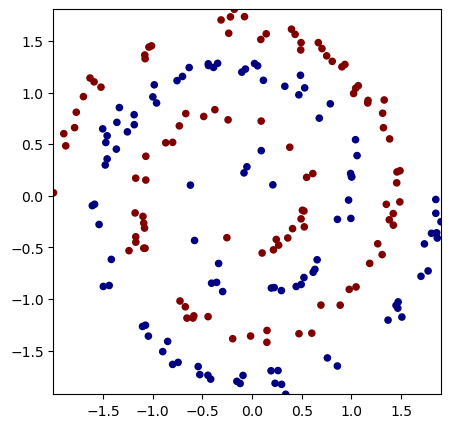

In [24]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


np.random.seed(1337)
random.seed(1337)


def make_spiral_dataset(n_samples=100, noise=0.2, x=(-1, 1), y=(-1, 1)):
    n = n_samples // 2  # Split samples between two spirals

    # Generate first spiral
    theta1 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r1 = 2 * theta1 + np.pi
    x1 = np.stack([r1 * np.cos(theta1), r1 * np.sin(theta1)], axis=1)

    # Generate second spiral
    theta2 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r2 = -2 * theta2 - np.pi
    x2 = np.stack([r2 * np.cos(theta2), r2 * np.sin(theta2)], axis=1)

    # Combine spirals and add noise
    X = np.vstack([x1, x2])
    X += np.random.randn(n_samples, 2) * noise

    # Scale X to fit within the specified x and y ranges
    X[:, 0] = np.interp(X[:, 0], (X[:, 0].min(), X[:, 0].max()), x)
    X[:, 1] = np.interp(X[:, 1], (X[:, 1].min(), X[:, 1].max()), y)

    # Create labels
    y = np.zeros(n_samples)
    y[:n] = 0  # First spiral
    y[n:] = 1  # Second spiral

    return X, y


# Usage example:
X, y = make_spiral_dataset(n_samples=200, noise=0.9, x=(-1, 1), y=(-1, 1))

# Normilize
X = (X - X.mean(axis=0)) / X.std(axis=0)
# Reshape y
y = y.reshape(-1, 1)

print(X.shape, y.shape)

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")
plt.xlim(X[:, 0].min(), X[:, 0].max())
plt.ylim(X[:, 1].min(), X[:, 1].max())
plt.show()

In [ ]:
class FeedForwardNet(Module):
    def __init__(self, inputs: int, outputs: List[int]):
        layers = []
        for i in range(len(outputs) - 1):
            layers.append(Linear(outputs[i], outputs[i + 1], init_method="he_leaky"))
            # Apply LeakyReLU to all except the last layer
            if i < len(outputs) - 2:
                layers.append(LeakyReLU())

        # Add final Sigmoid for binary classification
        layers.append(Sigmoid())

        self.layers = Sequential(
            Linear(inputs, outputs[0]),
            Tanh(),
            *layers,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        return x

In [26]:
model = FeedForwardNet(2, [32, 16, 1])

model.params_count()

641

In [ ]:
X, y = Tensor(X), Tensor(y)

loss_fn = BCELoss()
# model = FeedForwardNet(2, [64, 32, 16, 1])
model = FeedForwardNet(2, [64, 32, 16, 1])
optimizer = SGD(model.parameters(), lr=0.2, momentum=0.9, clip_value=1.0)

training_steps = 1000

start_time = time.time()

for step in range(training_steps):
    optimizer.zero_grad()

    # Make predictions for this batch
    y_pred = model(X)

    # Compute the loss and its gradients
    loss = loss_fn(y_pred, y)
    loss.backward()

    # update
    optimizer.step()

    if step % 1 == 0:
        print(f"Step {step}, loss: {loss.data}")

end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

Step 0, loss: 0.7039712071418762
Step 1, loss: 0.6963165402412415
Step 2, loss: 0.6828614473342896
Step 3, loss: 0.667506992816925
Step 4, loss: 0.6537997126579285
Step 5, loss: 0.6474148631095886
Step 6, loss: 0.6466442942619324
Step 7, loss: 0.6487369537353516
Step 8, loss: 0.650516927242279
Step 9, loss: 0.6480689644813538
Step 10, loss: 0.6413301229476929
Step 11, loss: 0.6346226930618286
Step 12, loss: 0.6299131512641907
Step 13, loss: 0.62688809633255
Step 14, loss: 0.6252954006195068
Step 15, loss: 0.6243368983268738
Step 16, loss: 0.623955249786377
Step 17, loss: 0.6237249970436096
Step 18, loss: 0.6231852173805237
Step 19, loss: 0.6218039393424988
Step 20, loss: 0.6197398900985718
Step 21, loss: 0.6172490119934082
Step 22, loss: 0.6147220730781555
Step 23, loss: 0.6126308441162109
Step 24, loss: 0.6112285852432251
Step 25, loss: 0.6104132533073425
Step 26, loss: 0.6098676323890686
Step 27, loss: 0.6089630126953125
Step 28, loss: 0.607708752155304
Step 29, loss: 0.6061794757843

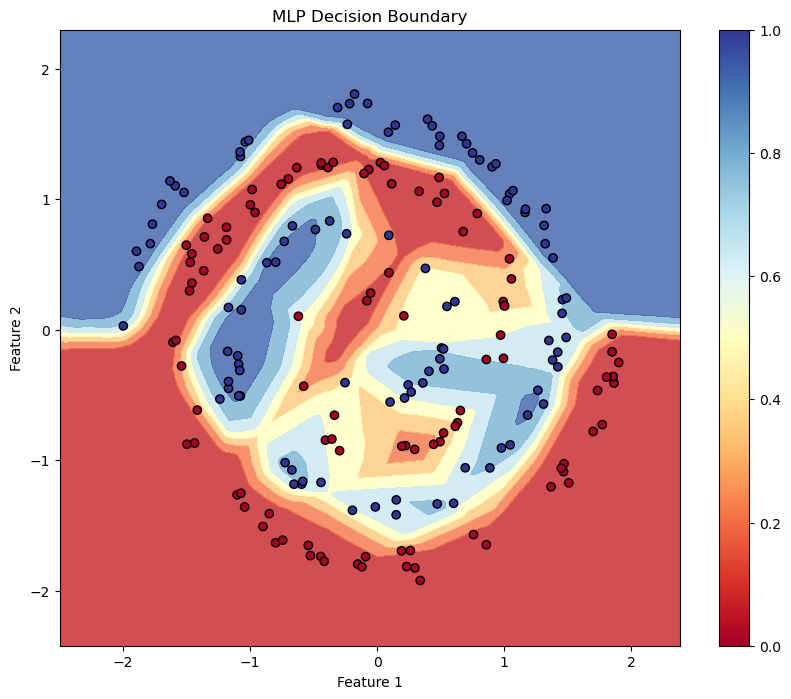

In [28]:
# Create a grid of points for visualization
x_min, x_max = X[:, 0].data.min() - 0.5, X[:, 0].data.max() + 0.5
y_min, y_max = X[:, 1].data.min() - 0.5, X[:, 1].data.max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Make predictions on the grid points
# model.eval()
Z = model(Tensor(grid_points)).data.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)

# Plot the original data points
plt.scatter(X[:, 0].data, X[:, 1].data, c=y.data, cmap=plt.cm.RdYlBu, edgecolors="black")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("MLP Decision Boundary")
plt.colorbar()
plt.show()

In [29]:
from dataclasses import dataclass
from typing import Union, List, Callable, Optional, Tuple, Literal

import numpy as np

Scalar = Union[int, float]

Data = Union[Scalar, list, np.ndarray, "Tensor"]


@dataclass(frozen=True)
class Leaf:
    value: "Tensor"
    grad_fn: Callable[[np.ndarray], np.ndarray]


class Tensor:
    def __init__(
        self,
        data: Data,
        requires_grad: bool = False,
        dependencies: Optional[List[Leaf]] = None,
        dtype=np.float32
    ):
        self._data = Tensor.build_ndarray(data, dtype)
        self.dtype = dtype

        self.requires_grad = requires_grad
        self.dependencies = dependencies or []

        self.grad = np.zeros_like(self._data) if requires_grad else None

    @property
    def data(self) -> np.ndarray:
        return self._data

    @data.setter
    def data(self, data: Data):
        self._data = Tensor.build_ndarray(data, self.dtype)
        if self.requires_grad:
            self.zero_grad()

    @property
    def size(self) -> int:
        return self.data.size

    @property
    def shape(self) -> Tuple[int, ...]:
        return self.data.shape

    @property
    def ndim(self) -> int:
        return self.data.ndim

    @staticmethod
    def build_ndarray(data: Data, dtype=np.float32) -> np.ndarray:
        if isinstance(data, Tensor):
            return np.array(data.data, dtype=dtype)
        if isinstance(data, np.ndarray):
            return data.astype(dtype)
        return np.array(data, dtype=dtype)

    @staticmethod
    def data_gate(data_object: Data) -> "Tensor":
        r"""
        Ensures the input is a Tensor.
        
        Args:
            data_object (Data): The input data, which can be a Tensor or a compatible type.
        
        Returns:
            Tensor: The input converted to a Tensor if necessary.
        """
        if isinstance(data_object, Tensor):
            return data_object
        return Tensor(data_object)

    def __repr__(self):
        return f"Tensor({self.data}, requires_grad={self.requires_grad}, shape={self.shape})"

    def zero_grad(self):
        if self.grad is None:
            self.grad = np.zeros_like(self._data)
        else:
            self.grad.fill(0.0)

    def backward(self, grad: Optional[np.ndarray] = None) -> None:
        if not self.requires_grad:
            raise RuntimeError(
                "Cannot call backward() on a tensor that does not require gradients. "
                "If you need gradients, ensure that requires_grad=True when creating the tensor."
            )

        if grad is None:
            if self.shape == ():
                grad = np.array(1.0)
            else:
                raise ValueError("Grad must be provided if tensor has shape")
            
        self.grad = self.grad + grad

        for dependency in self.dependencies:
            backward_grad = dependency.grad_fn(grad)
            dependency.value.backward(backward_grad)

    def view(self, shape: Tuple[int, ...], stride: Tuple[int, ...] = None) -> "Tensor":
        r"""
        Reshape the tensor without changing its underlying data.

        This method returns a new `Tensor` object that shares the same data but is represented 
        with a different shape. The operation is efficient as it does not involve memory reallocation.

        Args:
            shape (Tuple[int, ...]): The desired shape of the tensor.
            stride (Tuple[int, ...], optional): The new stride of the tensor.
                If not specified, the stride is inferred automatically.

        Returns:
            Tensor: A new tensor with the same data but a different shape.

        Example:
            >>> x = Tensor(np.array([[1, 2, 3], [4, 5, 6]]), requires_grad=True)
            >>> y = x.view((3, 2))
            >>> print(y)
            Tensor([[1, 2],
                    [3, 4],
                    [5, 6]], requires_grad=True, shape=(3,2))

        Notes:
            - The returned tensor shares the same data as the original tensor.
            - If `requires_grad=True`, the backward function ensures gradients are reshaped correctly.
        """

        if stride is None:
            stride = self.data.strides  # Use default strides if not specified

        output = self.data.reshape(shape)  # Reshape without copying data
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward pass for tensor view operation.

                This function ensures that the incoming gradient is reshaped 
                back to the original shape of the tensor.

                Args:
                    grad (np.ndarray): The incoming gradient.

                Returns:
                    np.ndarray: The gradient reshaped to match the original tensor.
                """
                return grad.reshape(self.shape)

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        return Tensor(output, self.requires_grad, dependencies, dtype=self.dtype)

    def clip(self, min_value: Optional[float] = None, max_value: Optional[float] = None) -> "Tensor":
        r"""
        Clip the tensor's values to the range [min_value, max_value].

        Args:
            min_value (Optional[float]): The minimum value to clip to. If None, no lower bound is applied.
            max_value (Optional[float]): The maximum value to clip to. If None, no upper bound is applied.

        Returns:
            Tensor: A new tensor with values clipped to the specified range.
        """

        # Perform clipping on the data
        output = np.clip(self.data, min_value, max_value)

        # Track dependencies if requires_grad is True
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward function for the clip operation.

                The gradient is passed through for values within the range [min_value, max_value].
                For values outside this range, the gradient is zero because the operation is not differentiable
                at the boundaries.

                Args:
                    grad (np.ndarray): The gradient passed from the downstream operation.

                Returns:
                    np.ndarray: The gradient for the input tensor.
                """

                # Create a mask for values within the clipping range
                mask = np.ones_like(self.data)

                # Apply the mask
                if min_value is not None:
                    mask[self.data <= min_value] = 0
                if max_value is not None:
                    mask[self.data >= max_value] = 0

                # Multiply the gradient by the mask
                return grad * mask

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        # Return a new tensor with the clipped values and dependencies
        return Tensor(output, self.requires_grad, dependencies)

    def __getitem__(self, index) -> "Tensor":
        r"""
        Perform indexing on the tensor.

        This method allows for selecting specific elements from the tensor using 
        standard NumPy indexing (e.g., slices, integers, tuples, etc.).

        Args:
            index: The indices to select from the tensor. This can be a slice, integer, 
                tuple, or any valid NumPy indexing type.

        Returns:
            Tensor: A new tensor containing the selected elements.

        Example:
            >>> x = Tensor([[1, 2, 3], [4, 5, 6]], requires_grad=True)
            >>> y = x[0, 1:3]  # Selects elements [2, 3]
            >>> print(y)
            Tensor([2, 3], requires_grad=True, shape=(2,))

        Notes:
            - If `requires_grad=True`, the backward function ensures that the gradient 
            is only applied to the indexed positions.
        """

        # Perform indexing operation
        output = self.data[index]

        # Track dependencies if requires_grad is True
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward pass for tensor indexing.

                This function constructs a zero tensor of the same shape as the original 
                tensor and assigns the incoming gradient only to the indexed positions.

                Args:
                    grad (np.ndarray): Gradient from the next layer.

                Returns:
                    np.ndarray: Gradient propagated back to the indexed positions.
                """
                full_grad = np.zeros_like(self.data)
                full_grad[index] = grad
                return full_grad

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        # Return a new tensor with the indexed data and dependencies
        return Tensor(output, self.requires_grad, dependencies)

    # Comparison Operators

    def __lt__(self, other: Data) -> "Tensor":
        r"""
        Element-wise less-than comparison.

        Args:
            other (Data): The other operand, which can be a Tensor, scalar, or array.

        Returns:
            Tensor: A boolean tensor where each element is True if the corresponding
                    element in `self` is less than `other`, otherwise False.
        """

        other = Tensor.data_gate(other)
        return Tensor(self.data < other.data)

    def __gt__(self, other: Data) -> "Tensor":
        r"""
        Element-wise greater-than comparison.

        Args:
            other (Data): The other operand, which can be a Tensor, scalar, or array.

        Returns:
            Tensor: A boolean tensor where each element is True if the corresponding
                    element in `self` is greater than `other`, otherwise False.
        """

        other = Tensor.data_gate(other)
        return Tensor(self.data > other.data)

    def __eq__(self, other: Data) -> "Tensor":
        r"""
        Element-wise equality comparison.

        Args:
            other (Data): The other operand, which can be a Tensor, scalar, or array.

        Returns:
            Tensor: A boolean tensor where each element is True if the corresponding
                    element in `self` is equal to `other`, otherwise False.
        """

        other = Tensor.data_gate(other)
        return Tensor(self.data == other.data)

    def __le__(self, other: Data) -> "Tensor":
        r"""
        Element-wise less-than-or-equal-to comparison.

        Args:
            other (Data): The other operand, which can be a Tensor, scalar, or array.

        Returns:
            Tensor: A boolean tensor where each element is True if the corresponding
                    element in `self` is less than or equal to `other`, otherwise False.
        """

        other = Tensor.data_gate(other)
        return Tensor(self.data <= other.data)

    def __ge__(self, other: Data) -> "Tensor":
        r"""
        Element-wise greater-than-or-equal-to comparison.

        Args:
            other (Data): The other operand, which can be a Tensor, scalar, or array.

        Returns:
            Tensor: A boolean tensor where each element is True if the corresponding
                    element in `self` is greater than or equal to `other`, otherwise False.
        """

        other = Tensor.data_gate(other)
        return Tensor(self.data >= other.data)

    def __ne__(self, other: Data) -> "Tensor":
        r"""
        Element-wise not-equal comparison.

        Args:
            other (Data): The other operand, which can be a Tensor, scalar, or array.

        Returns:
            Tensor: A boolean tensor where each element is True if the corresponding
                    element in `self` is not equal to `other`, otherwise False.
        """

        other = Tensor.data_gate(other)
        return Tensor(self.data != other.data)

    @staticmethod
    def where(condition: "Tensor", a: "Tensor", b: "Tensor") -> "Tensor":
        r"""
        Performs element-wise selection based on a condition.

        This function returns a tensor where each element is taken from `a` if the corresponding 
        element in `condition` is True, otherwise from `b`. It supports automatic differentiation.

        Args:
            condition (Tensor): A boolean tensor where True selects from `a`, and False selects from `b`.
            a (Tensor): The tensor providing values where `condition` is True.
            b (Tensor): The tensor providing values where `condition` is False.

        Returns:
            Tensor: A tensor with elements from `a` where `condition` is True, and from `b` otherwise.

        Example:
            >>> cond = Tensor(np.array([[True, False], [False, True]]))
            >>> x = Tensor(np.array([[1, 2], [3, 4]]), requires_grad=True)
            >>> y = Tensor(np.array([[10, 20], [30, 40]]), requires_grad=True)
            >>> result = Tensor.where(cond, x, y)
            >>> print(result)
            Tensor([[ 1, 20],
                    [30,  4]], requires_grad=True)

        Notes:
            - The returned tensor has `requires_grad=True` if either `a` or `b` requires gradients.
            - The backward function ensures gradients are passed only to the selected elements.
        """

        output = np.where(condition.data, a.data, b.data)  # Element-wise selection
        requires_grad = a.requires_grad or b.requires_grad
        dependencies: List[Leaf] = []

        if a.requires_grad:
            def _bkwd_a(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward function for `a`.

                This ensures gradients flow only to the elements selected from `a`.

                Args:
                    grad (np.ndarray): Gradient of the output tensor.

                Returns:
                    np.ndarray: Gradient for `a`, masked where `condition` is False.
                """
                return np.where(condition.data, grad, 0.0)

            dependencies.append(Leaf(a, _bkwd_a))

        if b.requires_grad:
            def _bkwd_b(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward function for `b`.

                This ensures gradients flow only to the elements selected from `b`.

                Args:
                    grad (np.ndarray): Gradient of the output tensor.

                Returns:
                    np.ndarray: Gradient for `b`, masked where `condition` is True.
                """
                return np.where(condition.data, 0.0, grad)

            dependencies.append(Leaf(b, _bkwd_b))

        return Tensor(output, requires_grad, dependencies)

    def transpose(self, axes: Tuple[int, ...] = None) -> "Tensor":
        output = np.transpose(self.data, axes=axes)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            return np.transpose(grad, axes=axes)
        
        if self.requires_grad:
            dependencies.append(
                Leaf(value=self, grad_fn=_bkwd)
            )

        return Tensor(
            output,
            requires_grad=self.requires_grad,
            dependencies=dependencies
        )

    @property
    def T(self):
        return self.transpose()

    def squeeze(self, dim: int | Tuple[int] = 0) -> "Tensor":
        r"""
        Removes dimensions of size 1 from the specified axis.

        Args:
            dim (int or Tuple[int]): The axis or axes to squeeze. Defaults to 0.

        Returns:
            Tensor: The squeezed tensor with tracked dependencies.
        """
        output = np.squeeze(self.data, axis=dim)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            r"""
            Backward function for squeeze operation.

            Args:
                grad (np.ndarray): Incoming gradient.

            Returns:
                np.ndarray: Expanded gradient to match original dimensions.
            """
            return np.expand_dims(grad, axis=dim)

        if self.requires_grad:
            dependencies.append(
                Leaf(value=self, grad_fn=_bkwd)
            )

        return Tensor(output, self.requires_grad, dependencies)
    
    def unsqueeze(self, dim: Tuple[int] = 0) -> "Tensor":
        r"""
        Adds a singleton dimension at the specified axis.

        Args:
            dim (Tuple[int]): The axis at which to insert a new dimension. Defaults to 0.

        Returns:
            Tensor: The unsqueezed tensor with tracked dependencies.
        """
        output = np.expand_dims(self.data, axis=dim)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            r"""
            Backward function for unsqueeze operation.

            Args:
                grad (np.ndarray): Incoming gradient.

            Returns:
                np.ndarray: Squeezed gradient to remove added dimension.
            """
            return np.squeeze(grad, axis=dim)

        if self.requires_grad:
            dependencies.append(
                Leaf(value=self, grad_fn=_bkwd)
            )

        return Tensor(output, self.requires_grad, dependencies)

    @staticmethod
    def matmul(a: "Tensor", b: "Tensor") -> "Tensor":
        r"""
        Static method to perform matrix multiplication of two tensors.

        Args:
            a (Tensor): First matrix.
            b (Tensor): Second matrix.

        Returns:
            Tensor: Resulting tensor with tracked dependencies.
        """
        
        output = a.data @ b.data
        requires_grad = a.requires_grad or b.requires_grad
        dependencies: List[Leaf] = []

        if a.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward gradient function for matmul with respect to a.
                """

                if b.ndim > 1:
                    return grad @ b.data.swapaxes(-1, -2)
                return np.outer(grad, b.data.T).squeeze()

            dependencies.append(
                Leaf(
                    value=a,
                    grad_fn=_bkwd
                )
            )

        if b.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                r"""
                Backward gradient function for matmul with respect to b.
                """

                if a.ndim > 1:
                    return a.data.swapaxes(-1, -2) @ grad
                return np.outer(a.data.T, grad).squeeze()
            
            dependencies.append(
                Leaf(
                    value=b,
                    grad_fn=_bkwd
                )
            )

        return Tensor(output, requires_grad, dependencies)

    def dot(self, other: Data) -> "Tensor":
        r"""
        Perform matrix dot product with another tensor or data.

        Args:
            other (Data): The other operand.

        Returns:
            Tensor: Result of the dot product.
        """

        return Tensor.matmul(self, Tensor.data_gate(other))

    def __matmul__(self, other: Data) -> "Tensor":
        r"""
        Overload the `@` operator for matrix multiplication.

        Args:
            other (Data): The other operand.

        Returns:
            Tensor: Result of the matrix multiplication.
        """

        return self.dot(Tensor.data_gate(other))

    def abs(self) -> "Tensor":
        r"""
        Computes the absolute value of the tensor's elements.

        The absolute value of each element is computed element-wise, and the result is returned as a new tensor.

        Returns:
            Tensor: A new tensor containing the absolute values of the input tensor's elements.
        
        The derivative of the absolute value function is handled in the backward pass using the sign of the input tensor.
        The gradient for positive values is 1, for negative values is -1, and the gradient is undefined at zero.
        """

        # Perform absolute value operation on the data
        output = np.abs(self.data)

        # Initialize the list of dependencies for gradient calculation
        dependencies: List[Leaf] = []

        # Backward function to compute the gradient for the absolute value operation
        def _bkwd(grad: np.ndarray) -> np.ndarray:
            r"""
            Compute the gradient of the absolute value operation.
            
            Args:
                grad (np.ndarray): The gradient passed from the downstream operation.
            
            Returns:
                np.ndarray: The gradient for the input tensor.
            
            The gradient of abs(x) is the sign of x:
            - If x > 0, the gradient is 1.
            - If x < 0, the gradient is -1.
            - The gradient is undefined at x = 0.
            """

            # The derivative of abs(x) is the sign of x: 1 for positive x, -1 for negative x
            return grad * np.sign(self.data)

        # If the tensor requires gradients, add the backward function to the dependencies list
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,  # The input tensor
                    grad_fn=_bkwd  # The backward function to compute the gradients
                )
            )

        # Return a new tensor containing the absolute values, with the gradient dependencies if needed
        return Tensor(output, self.requires_grad, dependencies)

    def max(self, axis: Optional[int] = None, keepdims: bool = False) -> "Tensor":
        r"""
        Computes the maximum value along the specified axis.

        This function returns the maximum value(s) of the tensor, either element-wise (if no axis is specified) 
        or along a given axis. The backward pass ensures that only the maximum elements receive gradients.

        Args:
            axis (Optional[int]): The axis along which to compute the maximum.
                If None, the maximum of the entire tensor is returned.
            keepdims (bool): If True, retains reduced dimensions with size 1.
        
        Returns:
            Tensor: A new tensor containing the maximum values along the given axis.

        The gradient is computed during backpropagation by assigning a gradient of 1 
        to the maximum element(s) and 0 elsewhere.
        """

        # Compute the maximum along the specified axis
        output = np.max(self.data, axis=axis, keepdims=keepdims)

        # Track dependencies if requires_grad is True
        dependencies: List[Leaf] = []

        if self.requires_grad:
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                r"""
                Compute the gradient of the max operation.

                Args:
                    grad (np.ndarray): The gradient passed from the downstream operation.

                Returns:
                    np.ndarray: The gradient for the input tensor.

                The gradient is 1 for the maximum element(s) and 0 elsewhere.
                """
                
                grad_expanded = np.expand_dims(grad, axis) if axis is not None else grad
                mask = self.data == np.expand_dims(output, axis) if axis is not None else self.data == output
                return grad_expanded * mask.astype(self.data.dtype)

            dependencies.append(Leaf(value=self, grad_fn=_bkwd))

        return Tensor(output, self.requires_grad, dependencies)

    def sum(self, axis: int = None, keepdims: bool = False) -> "Tensor":
        r"""
        Computes the sum of all elements in the tensor along a specified axis.

        Args:
            axis (int or tuple of ints, optional): Axis or axes along which a sum is performed. 
                The default is to sum over all dimensions.
            keepdims (bool, optional): If True, the reduced axes are retained with length 1, 
                otherwise the result is reshaped to eliminate the reduced axes. Default is False.

        Returns:
            Tensor: A new tensor with the summed values and the gradient dependencies.
        """
        # Perform summation over specified axis
        output = self.data.sum(axis=axis, keepdims=keepdims)

        # Initialize the list of dependencies for gradient calculation
        dependencies: List[Leaf] = []

        # Backward function to calculate the gradients for the sum operation
        def _bkwd(grad: np.ndarray) -> np.ndarray:
            r"""
            Compute the gradient of the sum operation. The gradient is summed along the specified axis.
            
            Args:
                grad (np.ndarray): The gradient passed from the downstream operation.

            Returns:
                np.ndarray: The gradient for the input tensor.
            
            If `keepdims` is True, the gradient is broadcasted to match the original tensor's dimensions.
            """
            if keepdims:
                # If keepdims is True, we need to expand the gradient dimensions to match the input tensor
                expanded_grad = np.expand_dims(grad, axis=axis)
                ones = np.ones_like(expanded_grad)  # Create a tensor of ones to match the expanded gradient
                grad = expanded_grad * ones  # Broadcast the gradient to the correct shape
            # Sum the gradients along the specified axis
            return np.sum(grad, axis=axis)

        # If the tensor requires gradients, add the backward function to the dependencies list
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,  # The input tensor
                    grad_fn=_bkwd  # The backward function to compute the gradients
                )
            )

        # Return a new tensor containing the sum, with the gradient dependencies if needed
        return Tensor(output, self.requires_grad, dependencies)

    def mean(self, axis: Optional[int] = None, keepdims: bool = False) -> "Tensor":
        r"""
        Computes the mean of all elements in the tensor.

        The mean is calculated as the sum of all elements divided by the total number of elements in the tensor.

        Args:
            axis (int or tuple of ints, optional): Axis or axes along which a mean is performed.
                The default is to compute the mean of the flattened array.
            keepdims (bool, optional): If True, the reduced axes are retained with length 1,
                otherwise the result is reshaped to eliminate the reduced axes. Default is False.
        Returns:
            Tensor: A new tensor containing the mean of all elements in the input tensor.

        The mean is calculated using the formula:
            mean = sum(elements) / number_of_elements
        """

        # Mean is simply sum divided by the size of the tensor
        # First, we calculate the sum of all elements, then divide by the total number of elements (size)
        return self.sum(axis=axis, keepdims=keepdims) / self.size

    def log(self) -> "Tensor":
        r"""
        Computes the natural logarithm of all elements in the tensor.

        The logarithm is applied element-wise to the tensor's data. This function assumes that 
        the data values are positive, as the logarithm of non-positive values is undefined.

        Returns:
            Tensor: A new tensor containing the element-wise natural logarithm of the input tensor.
        
        The natural logarithm of a value `x` is calculated as:
            log(x) = ln(x)
        
        The derivative of log(x) with respect to x is:
            d/dx log(x) = 1/x
        """

        # Perform logarithmic operation on the data
        output = np.log(self.data)
        
        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            r"""
            Backward pass for the logarithm operation.
            
            The derivative of the logarithm is 1/x, so we compute the gradient as:
                grad(x) = grad(x) / x
                
            Args:
                grad (np.ndarray): The gradient propagated from the next layer.
            
            Returns:
                np.ndarray: The gradient to propagate backward.
            """

            # The derivative of log(x) is 1/x, so we divide the gradient by the data (x)
            return grad / self.data

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the log operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    def tanh(self) -> "Tensor":
        """
        Computes the hyperbolic tangent (tanh) of all elements in the tensor.

        The hyperbolic tangent function is applied element-wise to the tensor's data. The tanh 
        function maps the input values to the range (-1, 1).
        
        Returns:
            Tensor: A new tensor containing the element-wise hyperbolic tangent of the input tensor.

        The hyperbolic tangent function is defined as:
            tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))

        The derivative of tanh(x) with respect to x is:
            d/dx tanh(x) = 1 - tanh(x)^2
        """
        # Perform hyperbolic tangent operation on the data
        output = np.tanh(self.data)
        
        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            """
            Backward pass for the tanh operation.
            
            The derivative of tanh(x) is 1 - tanh(x)^2, so we compute the gradient as:
                grad(x) = grad(x) * (1 - tanh(x)^2)
            
            Args:
                grad (np.ndarray): The gradient propagated from the next layer.
            
            Returns:
                np.ndarray: The gradient to propagate backward.
            """
            
            # The derivative of tanh(x) is 1 - tanh(x)^2, so we multiply the gradient by this value
            return grad * (1 - output**2)

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the tanh operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    def pow(self, pow: Scalar) -> "Tensor":
        r"""
        Computes the element-wise power of the tensor's data.

        The operation applies the power function element-wise, raising each element in the tensor 
        to the given power `pow`.

        Args:
            pow (Scalar): The exponent to which each element in the tensor should be raised.

        Returns:
            Tensor: A new tensor where each element is raised to the specified power.

        The power function is defined as:
            y = x^pow, where `x` is the input tensor's element and `pow` is the given exponent.

        The derivative of x^pow with respect to x is:
            d/dx (x^pow) = pow * x^(pow - 1)
        """
        # Perform element-wise power operation (raise each element to the given power)
        output = self.data**pow
        
        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            r"""
            Backward pass for the power operation.
            
            The derivative of x^pow with respect to x is:
                d/dx (x^pow) = pow * x^(pow - 1)
            
            We multiply the gradient by the derivative to propagate the gradient backward.
            
            Args:
                grad (np.ndarray): The gradient propagated from the next layer.
            
            Returns:
                np.ndarray: The gradient to propagate backward.
            """
            # The derivative of x^pow is pow * x^(pow - 1), so we multiply the gradient by this value
            return grad * (pow * (self.data**(pow - 1)))

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the power operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    def __pow__(self, pow: Scalar) -> "Tensor":
        r"""
        Overload the `**` operator for element-wise exponentiation.

        Args:
            pow (Scalar): The exponent to raise the tensor to.

        Returns:
            Tensor: A new tensor with each element raised to the given power.
        """

        return self.pow(pow)
    
    def exp(self) -> "Tensor":
        r"""
        Computes the element-wise exponential of the tensor's data.

        The operation applies the exponential function element-wise, raising the constant e 
        (Euler's number) to the power of each element in the tensor.

        Returns:
            Tensor: A new tensor where each element is the exponential of the corresponding element 
            in the input tensor.

        The exponential function is defined as:
            y = e^x, where `e` is Euler's number (approximately 2.71828), and `x` is the input tensor's element.

        The derivative of e^x with respect to x is:
            d/dx (e^x) = e^x
        """

        # Perform element-wise exponential operation (raise e to the power of each element)
        output = np.exp(self.data)

        # Initialize an empty list for dependencies (used for backpropagation)
        dependencies: List[Leaf] = []

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            """
            Backward pass for the exponential operation.
            
            The derivative of e^x with respect to x is:
                d/dx (e^x) = e^x
            
            We multiply the gradient by e^x to propagate the gradient backward.
            
            Args:
                grad (np.ndarray): The gradient propagated from the next layer.
            
            Returns:
                np.ndarray: The gradient to propagate backward.
            """
            # The derivative of e^x is e^x, so we multiply the gradient by the output value
            return grad * output

        # If the tensor requires gradients (i.e., it's part of the computation graph), 
        # we store the backward function in the dependencies.
        if self.requires_grad:
            dependencies.append(
                Leaf(
                    value=self,
                    grad_fn=_bkwd
                )
            )

        # Return a new Tensor containing the result of the exponential operation and the necessary dependencies.
        return Tensor(output, self.requires_grad, dependencies)

    @staticmethod
    def _bkwd_broadcast(tensor: "Tensor"):
        r"""
        Backward closure function to sum across broadcasted dimensions.
        
        When performing operations between tensors of different shapes, broadcasting is used
        to align their shapes. This function ensures that the gradients are correctly summed
        over the broadcasted dimensions during the backward pass.

        Args:
            tensor (Tensor): The tensor involved in the operation, used to handle its shape 
                            during backward gradient computation.

        Returns:
            _bkwd (function): A function that computes the gradient, summing over broadcasted 
                            dimensions to match the original tensor's shape.
        """

        def _bkwd(grad: np.ndarray) -> np.ndarray:
            # If the gradient is a scalar, return it as is
            if grad.ndim == 0:
                return grad

            # Calculate the number of extra dimensions added during broadcasting
            dimensions = grad.ndim - tensor.ndim

            # Sum across the broadcasted dimensions (extra dimensions)
            for _ in range(dimensions):
                grad = grad.sum(axis=0, keepdims=True)
                # grad = grad.sum(axis=0)

            # Sum across singleton dimensions (dimensions with size 1)
            for index, dimension in enumerate(tensor.shape):
                if dimension == 1:
                    grad = grad.sum(axis=index, keepdims=True)

            # Return the gradient after the necessary reductions across dimensions
            return grad

        return _bkwd

        # def _bkwd(grad: np.ndarray) -> np.ndarray:
        #     # Calculate the number of extra dimensions added during broadcasting
        #     dimensions = grad.ndim - tensor.ndim
            
        #     # Sum across the broadcasted dimensions (extra dimensions)
        #     for _ in range(dimensions):
        #         grad = grad.sum(axis=0, keepdims=True)

        #     # Sum across singleton dimensions (dimensions with size 1)
        #     for index, dimension in enumerate(tensor.shape):
        #         if dimension == 1:
        #             grad = grad.sum(axis=index, keepdims=True)

        #     # Return the gradient after the necessary reductions across dimensions
        #     return grad

        # return _bkwd

    @staticmethod
    def add(a: "Tensor", b: "Tensor") -> "Tensor":
        r"""
        Add two tensors and return a new tensor containing the result.
        
        This method performs element-wise addition of two tensors, handling broadcasting 
        if necessary. If either tensor requires gradients, the resulting tensor will also 
        track gradients and backpropagate them correctly.

        Args:
            a (Tensor): The first tensor to be added.
            b (Tensor): The second tensor to be added.

        Returns:
            Tensor: A new tensor that contains the element-wise sum of a and b.
        """
        
        # Perform element-wise addition of the data of tensors a and b
        output = a.data + b.data
        
        # Determine if the result requires gradients (if any input tensor requires it)
        requires_grad = a.requires_grad or b.requires_grad
        
        # List to store dependencies (grad functions) for backpropagation
        dependencies: List[Leaf] = []

        # If tensor a requires gradients, add its gradient function to dependencies
        if a.requires_grad:
            dependencies.append(
                Leaf(value=a, grad_fn=Tensor._bkwd_broadcast(a))
            )

        # If tensor b requires gradients, add its gradient function to dependencies
        if b.requires_grad:
            dependencies.append(
                Leaf(value=b, grad_fn=Tensor._bkwd_broadcast(b))
            )

        # Return a new tensor with the result, gradient flag, and dependencies
        return Tensor(output, requires_grad, dependencies)
    
    def __add__(self, other: Data) -> "Tensor":
        r"""
        Overload the `+` operator to perform element-wise tensor addition.

        Args:
            other (Data): Another tensor or scalar to add.

        Returns:
            Tensor: The result of element-wise addition.
        """

        return Tensor.add(self, Tensor.data_gate(other))

    def __radd__(self, other: Data) -> "Tensor":
        r"""
        Overload the right-hand `+` operator (other + self).

        Args:
            other (Data): Another tensor or scalar to add.

        Returns:
            Tensor: The result of element-wise addition.
        """

        return Tensor.add(Tensor.data_gate(other), self)

    def __iadd__(self, other: Data) -> "Tensor":
        r"""
        Overload the `+=` operator for in-place addition.
        WARNING: In-place operations do not track gradients!

        Args:
            other (Data): Another tensor or scalar to add in-place.

        Returns:
            Tensor: The updated tensor after in-place addition.
        """

        self.data = self.data + Tensor.build_ndarray(other)
        return self

    def __neg__(self) -> "Tensor":
        r"""
        Overload the unary `-` operator to negate a tensor.
        This allows defining subtraction as addition with negation.

        Returns:
            Tensor: The negated tensor (-self).
        """

        output = -self.data
        dependencies: List[Leaf] = []

        # Define the backward function: gradient negation
        if self.requires_grad:
            dependencies.append(
                Leaf(value=self, grad_fn=lambda grad: -grad)
            )

        return Tensor(output, self.requires_grad, dependencies)

    def __sub__(self, other: Data) -> "Tensor":
        r"""
        Overload the `-` operator for element-wise subtraction.
        Uses addition with negation: a - b → a + (-b).

        Args:
            other (Data): Another tensor or scalar to subtract.

        Returns:
            Tensor: The result of element-wise subtraction.
        """

        return self + (-Tensor.data_gate(other))

    def __rsub__(self, other: Data) -> "Tensor":
        r"""
        Overload the right-hand `-` operator (other - self).
        Uses addition with negation: b - a → b + (-a).

        Args:
            other (Data): Another tensor or scalar.

        Returns:
            Tensor: The result of element-wise subtraction.
        """

        return Tensor.data_gate(other) + (-self)

    def __isub__(self, other: Data) -> "Tensor":
        r"""
        Overload the `-=` operator for in-place subtraction.
        WARNING: In-place operations do not track gradients!

        Args:
            other (Data): Another tensor or scalar to subtract in-place.

        Returns:
            Tensor: The updated tensor after in-place subtraction.
        """

        self.data = self.data - Tensor.build_ndarray(other)
        return self
    
    @staticmethod
    def mul(a: "Tensor", b: "Tensor") -> "Tensor":
        """
        Performs element-wise multiplication between two tensors and returns the result.
        Handles tensors that require gradients by defining the backward pass for backpropagation.

        Args:
            a (Tensor): First tensor to be multiplied.
            b (Tensor): Second tensor to be multiplied.

        Returns:
            Tensor: A new tensor containing the result of the element-wise multiplication.
        """
        # Ensure both tensors contain their data correctly, handling any potential gates
        a = Tensor.data_gate(a)
        b = Tensor.data_gate(b)

        # Perform element-wise multiplication on the tensor data
        output = a.data * b.data

        # Determine if the resulting tensor should require gradients
        requires_grad = a.requires_grad or b.requires_grad
        dependencies: List[Leaf] = []

        # Define the backward pass function for multiplication
        def _backward(a: Tensor, b: Tensor):
            """
            Backward closure function for Mul operation.
            Computes the gradient of the multiplication operation.
            """
            def _bkwd(grad: np.ndarray) -> np.ndarray:
                """
                The gradient of the multiplication operation.
                The gradient of a * b is grad * b for a and grad * a for b.
                """
                # Multiply the gradient by tensor b's data for the gradient w.r.t a
                grad = grad * b.data
                # Ensure the gradient is properly reshaped using broadcasting
                return Tensor._bkwd_broadcast(a)(grad)

            return _bkwd

        # If tensor a requires gradients, add the backward function to the dependencies
        if a.requires_grad:
            dependencies.append(
                Leaf(
                    value=a,
                    grad_fn=_backward(a, b)  # Link tensor a's backward pass
                )
            )

        # If tensor b requires gradients, add the backward function to the dependencies
        if b.requires_grad:
            dependencies.append(
                Leaf(
                    value=b,
                    grad_fn=_backward(b, a)  # Link tensor b's backward pass
                )
            )

        # Return the result as a new tensor, with the appropriate gradient information
        return Tensor(output, requires_grad, dependencies)

    def __mul__(self, other: Data) -> "Tensor":
        r"""
        Overloads the `*` operator for element-wise multiplication.
        
        This method ensures that Tensor multiplication can be performed seamlessly 
        with both other Tensors and scalar values.
        
        Args:
            other (Data): The other operand, which can be a Tensor or a compatible scalar.

        Returns:
            Tensor: A new Tensor representing the element-wise product.
        """

        return Tensor.mul(self, Tensor.data_gate(other))

    def __rmul__(self, other: Data) -> "Tensor":
        r"""
        Overloads the right-hand `*` operator.

        This ensures that multiplication works correctly when a scalar or another
        compatible type appears on the left side of the `*` operator.

        Args:
            other (Data): The left-hand operand, which can be a scalar or Tensor.

        Returns:
            Tensor: A new Tensor representing the element-wise product.
        """

        return Tensor.mul(Tensor.data_gate(other), self)

    def __imul__(self, other: Data) -> "Tensor":
        r"""
        Overloads the `*=` operator for in-place multiplication.

        This modifies the Tensor’s data directly, which improves efficiency.
        However, in-place operations do not support automatic differentiation
        (i.e., gradients will not be tracked).

        Args:
            other (Data): The operand to multiply with.

        Returns:
            Tensor: The modified Tensor after in-place multiplication.
        """

        self.data = self.data * Tensor.build_ndarray(other)
        return self

    def __truediv__(self, other: Data) -> "Tensor":
        r"""
        Overloads the `/` operator for element-wise division.

        Instead of direct division, this method multiplies the Tensor by the
        reciprocal of `other`, ensuring compatibility with automatic differentiation.

        Args:
            other (Data): The divisor, which can be a Tensor or a scalar.

        Returns:
            Tensor: A new Tensor representing the division result.
        """

        other = Tensor.data_gate(other)
        return self * (other**-1)

    def __rtruediv__(self, other: Data) -> "Tensor":
        r"""
        Overloads the right-hand `/` operator.

        This ensures that division works correctly when a scalar or another
        compatible type appears on the left side of the `/` operator.

        Args:
            other (Data): The numerator, which can be a scalar or Tensor.

        Returns:
            Tensor: A new Tensor representing the division result.
        """

        other = Tensor.data_gate(other)
        return other * (self**-1)

    def __itruediv__(self, other: Data) -> "Tensor":
        r"""
        Overloads the `/=` operator for in-place division.

        This modifies the Tensor’s data directly, improving efficiency.
        However, in-place operations do not support automatic differentiation
        (i.e., gradients will not be tracked).

        Args:
            other (Data): The divisor for in-place division.

        Returns:
            Tensor: The modified Tensor after in-place division.
        """

        self.data = self.data / Tensor.build_ndarray(other)
        return self